<a href="https://colab.research.google.com/github/LaviJ/Cryptocurrency-Analysis/blob/hourly-ML2/Machine%20Learning/model-predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

16384/6973 [======================================================================] - 0s 0s/step


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


16384/6790 [========================================================================] - 0s 0s/step


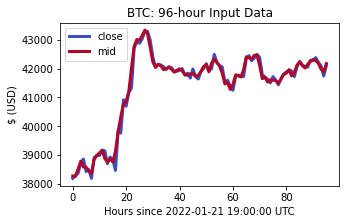

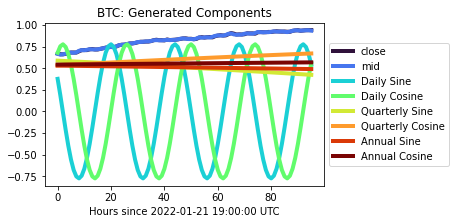

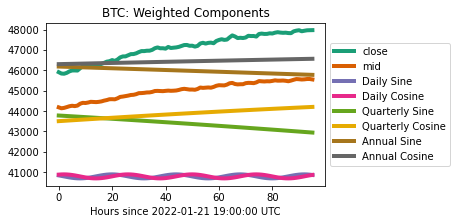

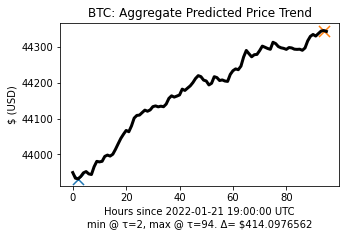

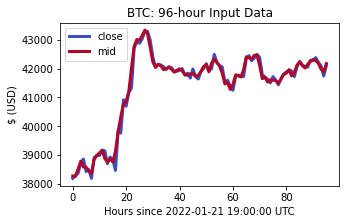

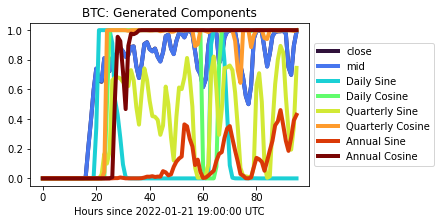

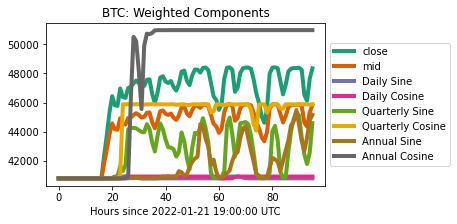

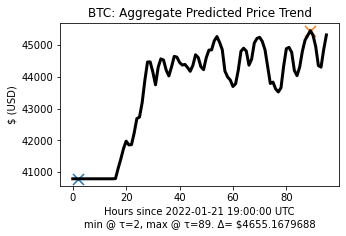

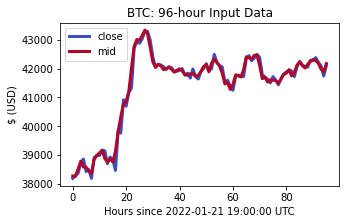

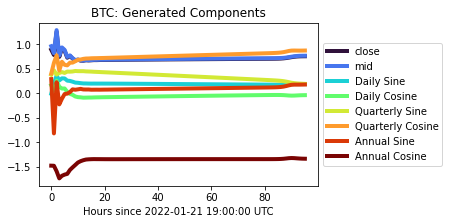

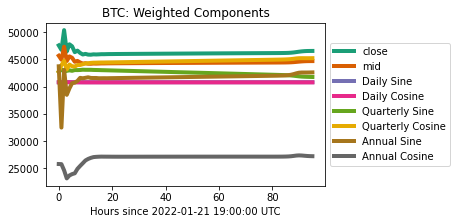

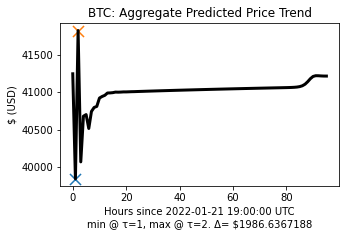

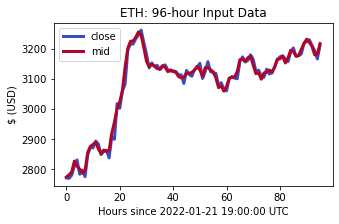

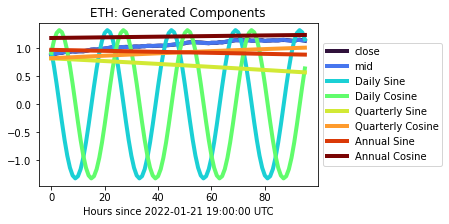

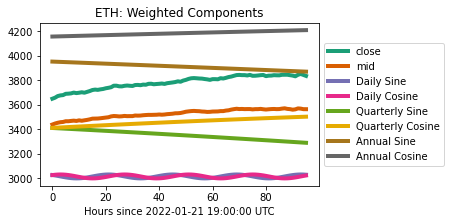

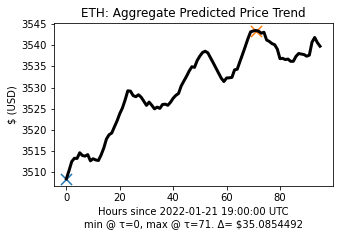

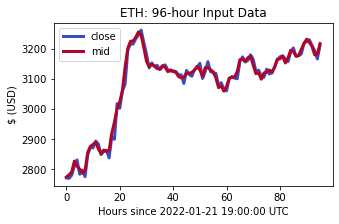

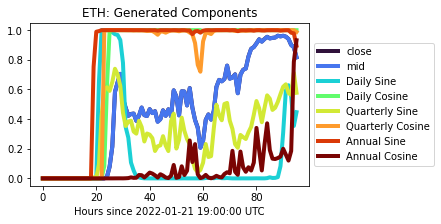

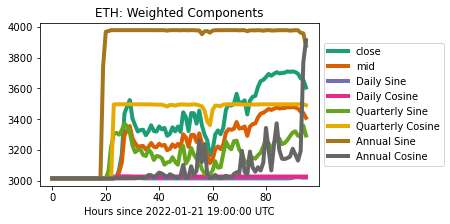

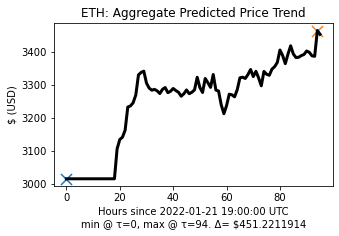

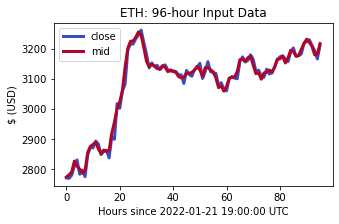

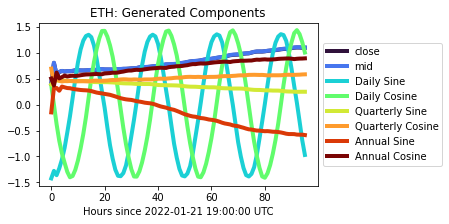

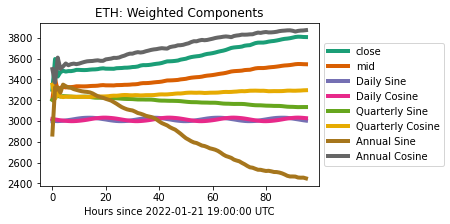

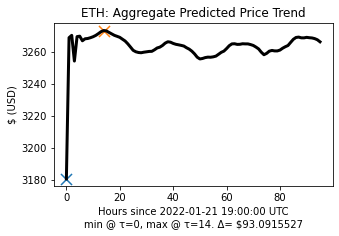

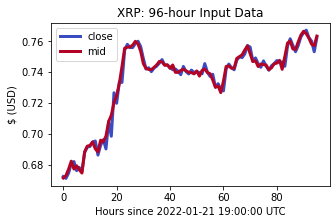

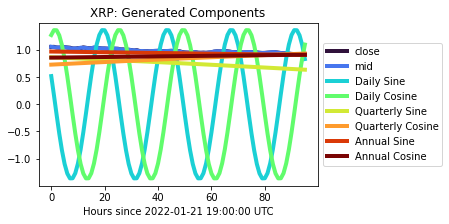

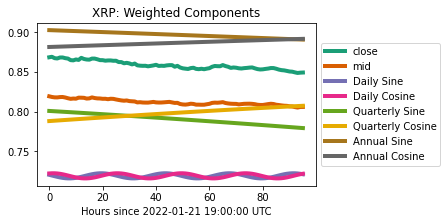

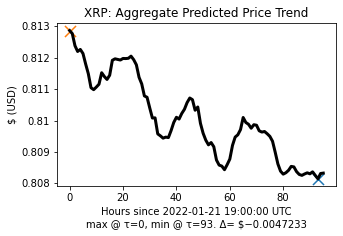

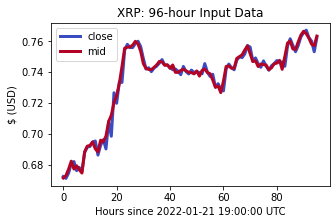

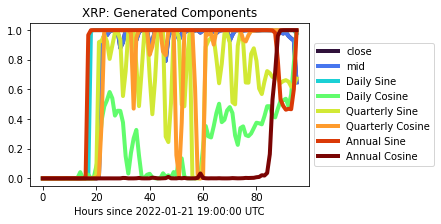

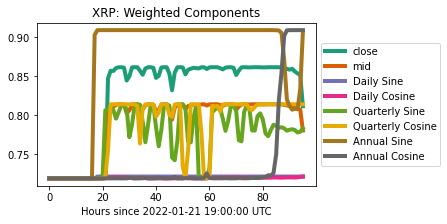

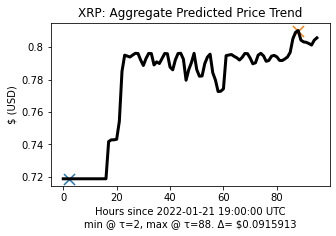

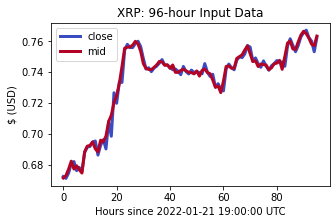

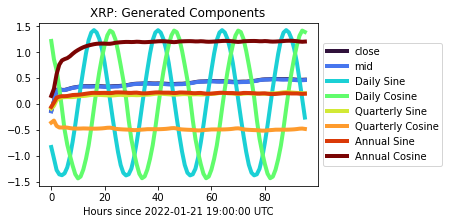

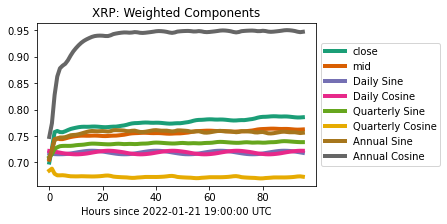

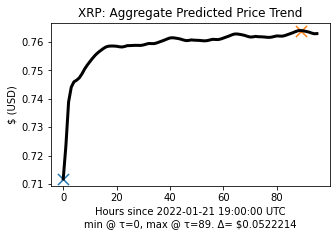

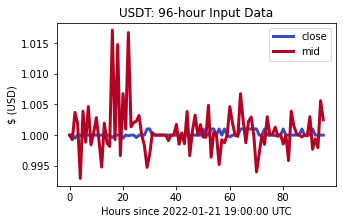

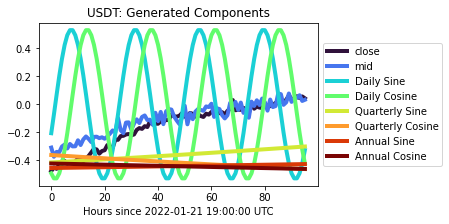

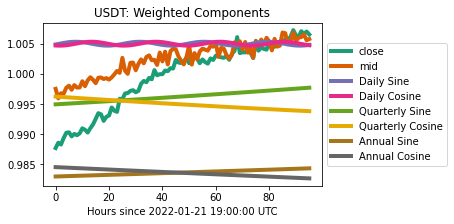

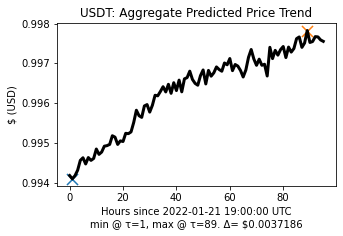

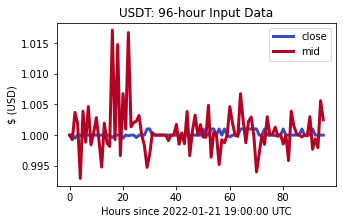

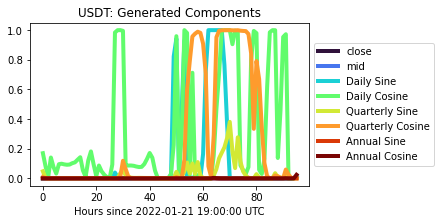

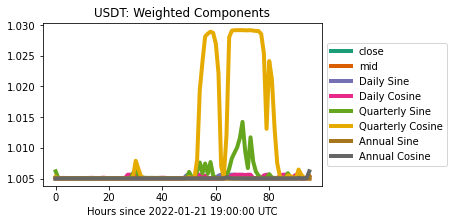

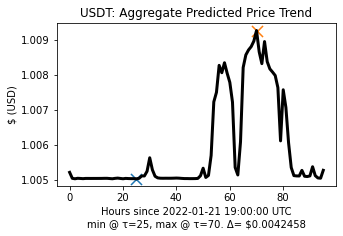

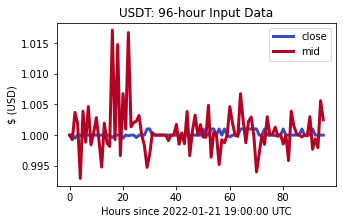

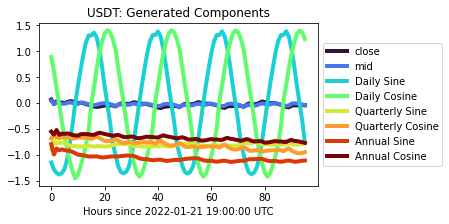

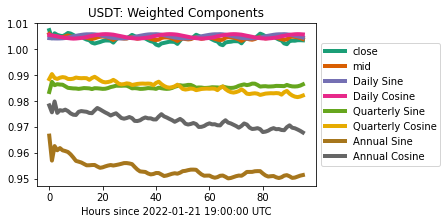

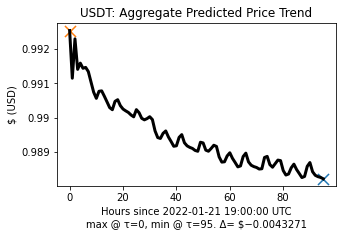

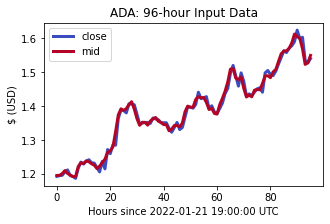

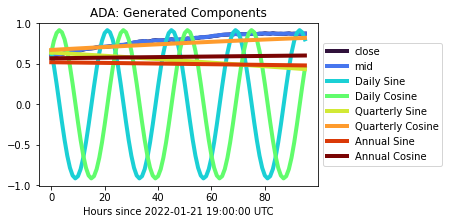

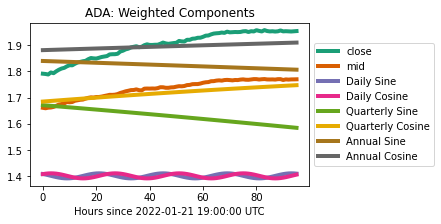

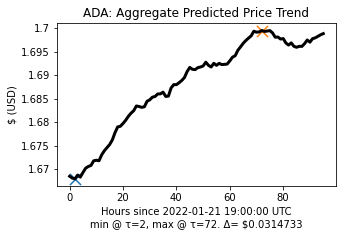

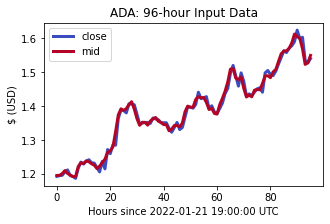

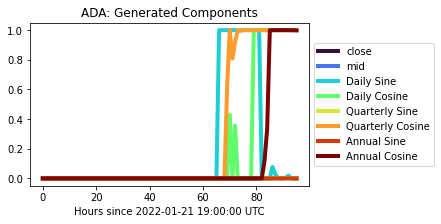

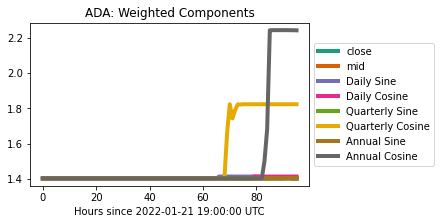

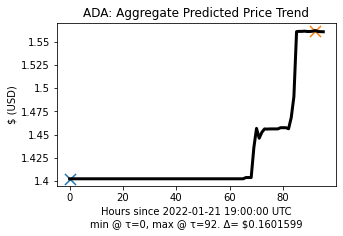

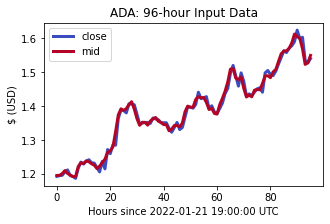

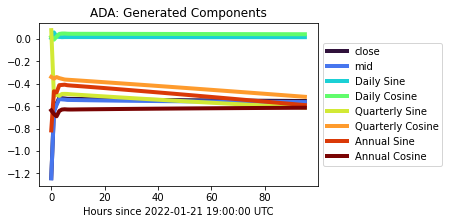

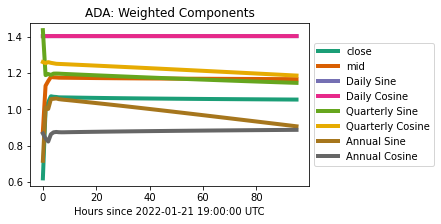

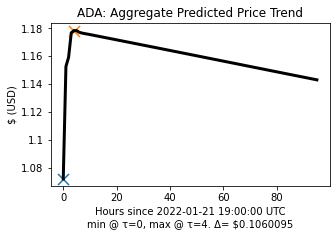

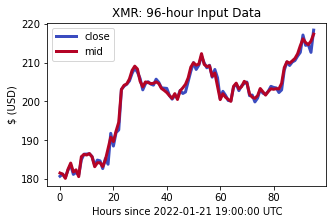

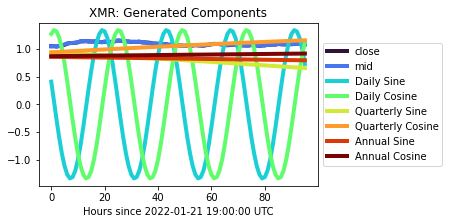

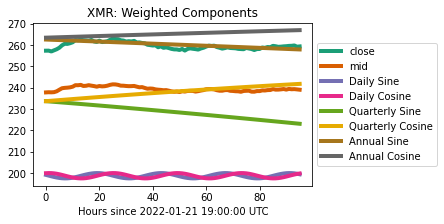

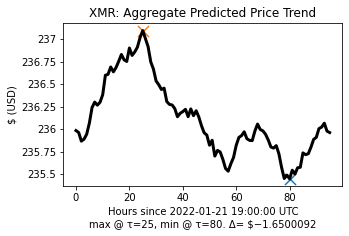

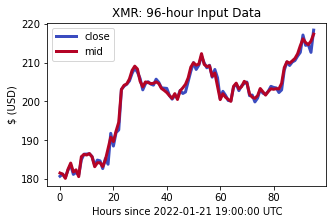

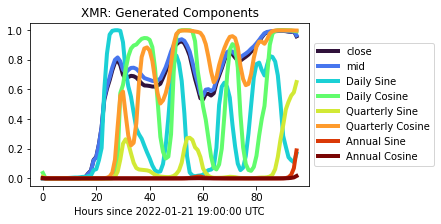

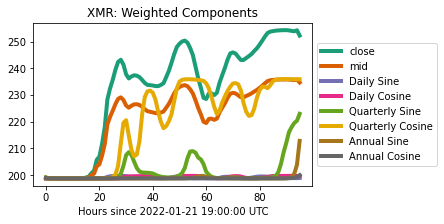

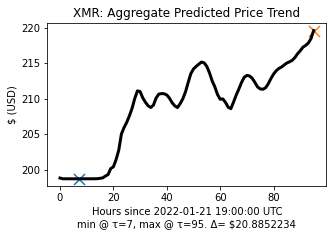

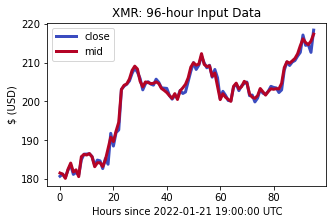

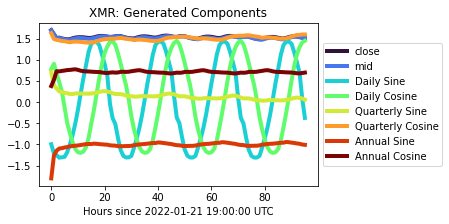

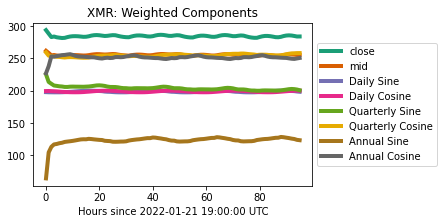

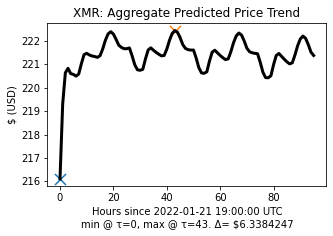

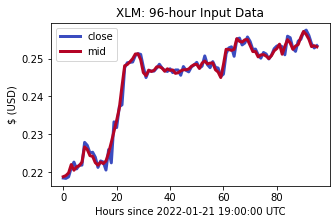

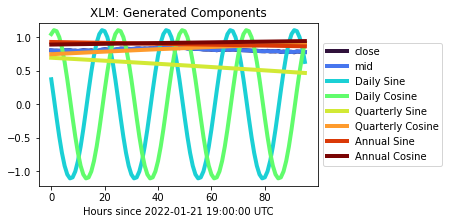

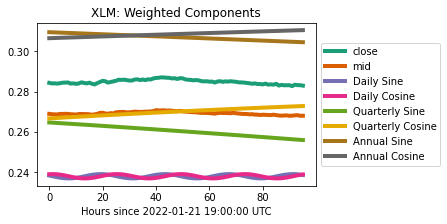

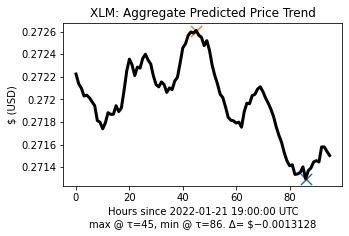

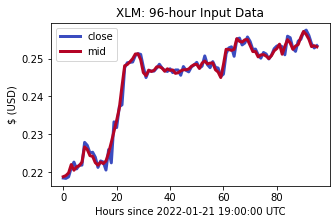

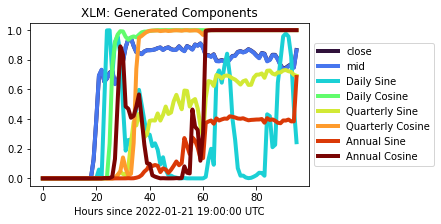

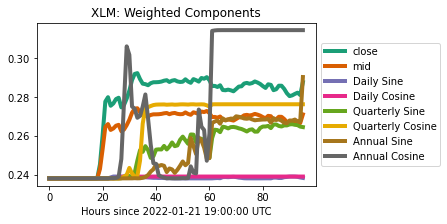

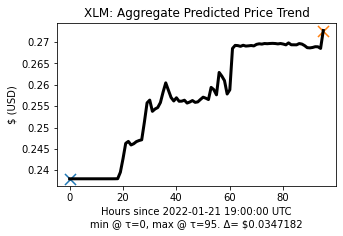

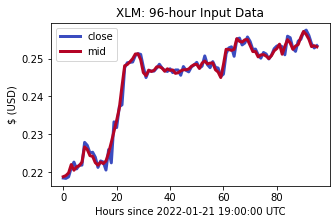

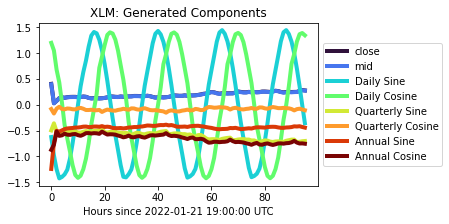

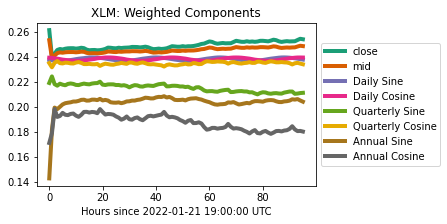

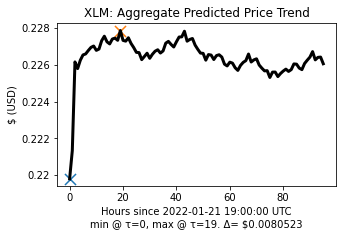

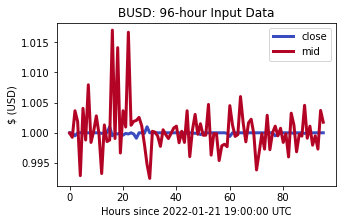

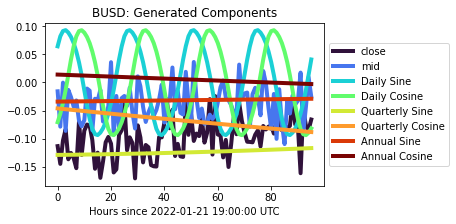

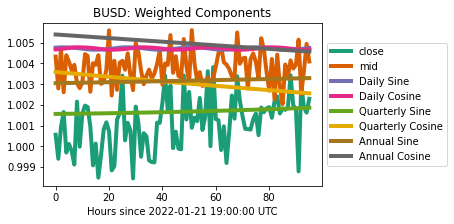

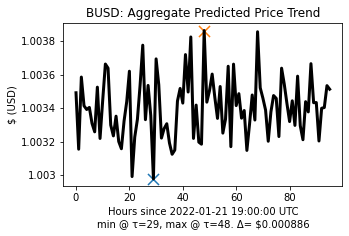

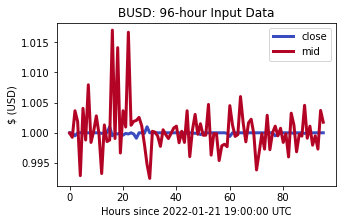

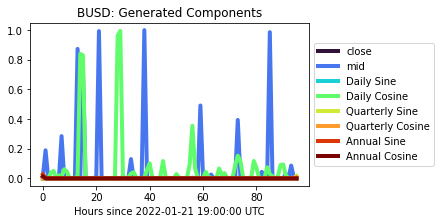

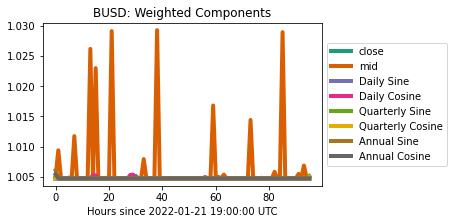

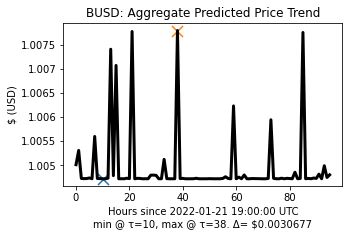

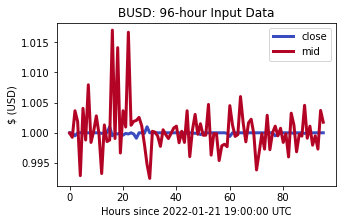

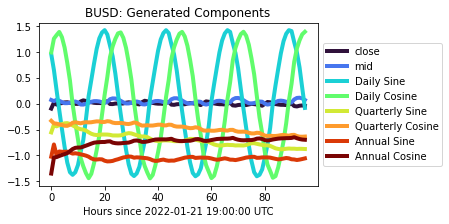

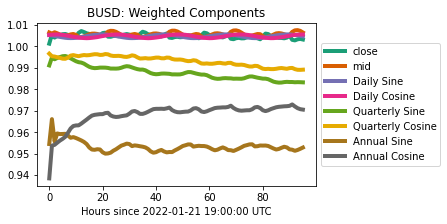

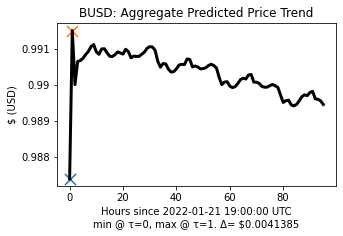

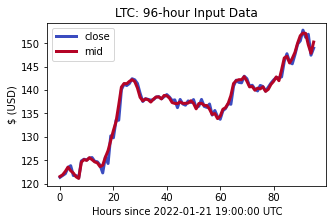

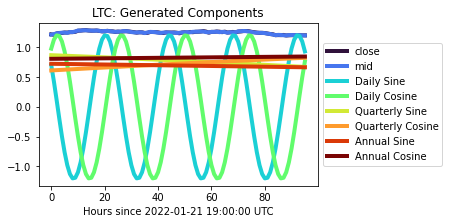

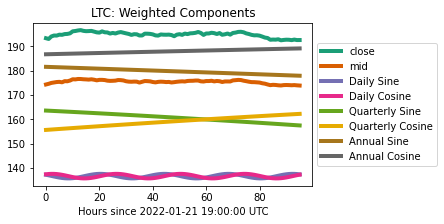

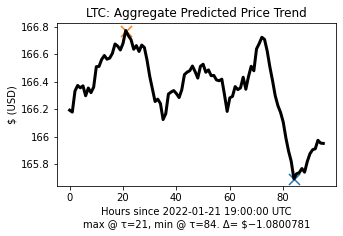

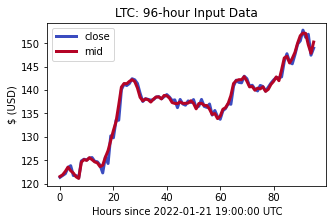

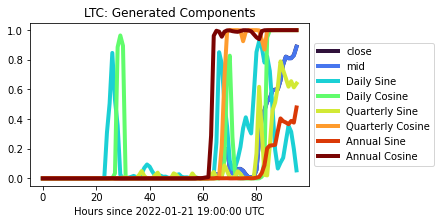

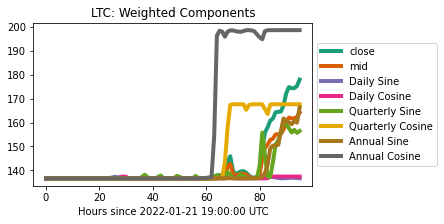

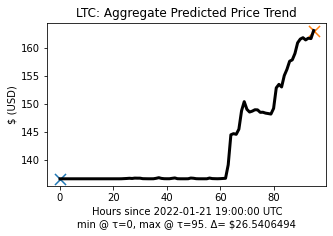

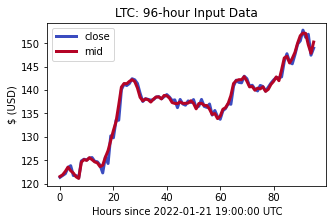

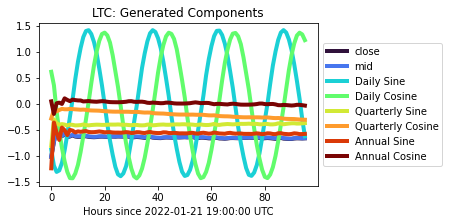

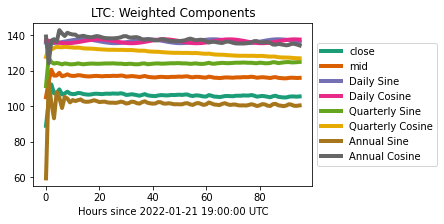

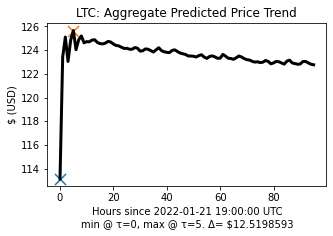

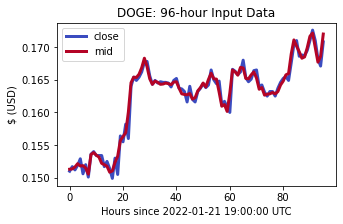

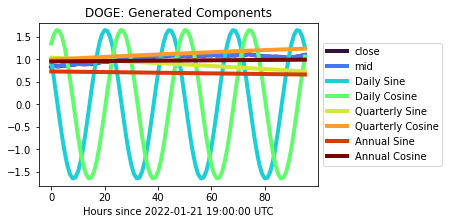

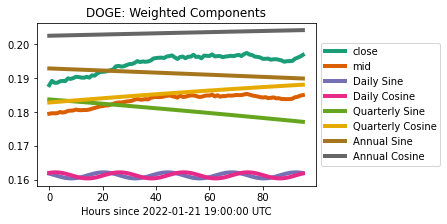

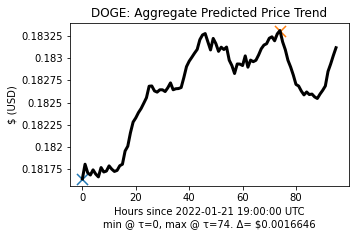

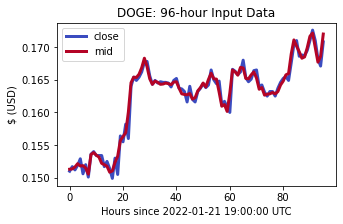

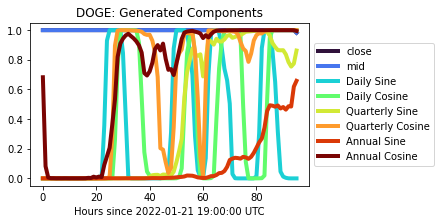

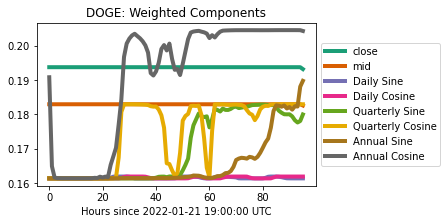

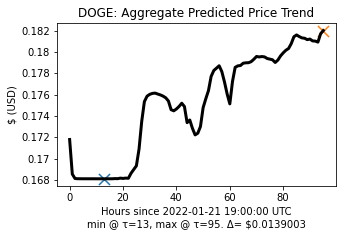

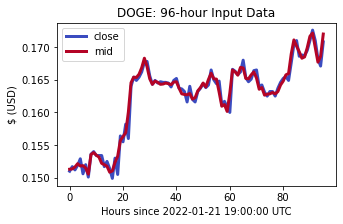

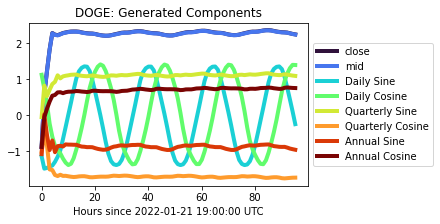

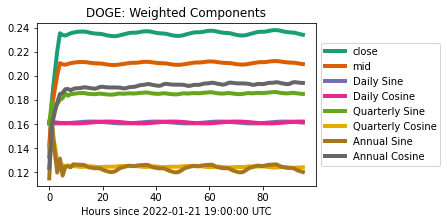

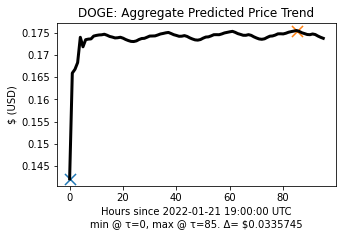

In [84]:
# Forcasting Cryptocurrency
# Data Analysis and Visualization
# Group 7

# TensorFlow model prediction routine

import os
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

symbols=['BTC','ETH','XRP','USDT','ADA','XMR','XLM','BUSD','LTC','DOGE']
modeltypes=['lstm','bidir','feedback']
testordinal='5'
for symbol in symbols:
  for modeltype in modeltypes:
    # Declare the dataframes
    train_df = val_df = test_df = df = pd.DataFrame()

    # Load the trained tensorflow model
    # TODO: make coin variable
    themodel = keras.models.load_model(symbol+modeltype+'_model')

    # Use Keras to get the data file
    path = tf.keras.utils.get_file(
        origin='https://raw.githubusercontent.com/LaviJ/Cryptocurrency-Analysis/main/Data/Hourly/Test'+testordinal+'/test'+testordinal+'_'+symbol+'.csv',
        fname='test'+testordinal+'_'+symbol+'.csv')
    csv_path, _ = os.path.splitext(path)

    # Read data into dataframe
    df = pd.read_csv(csv_path+".csv")

    # Drop some columns
    df = df.drop('conversionType', axis=1)
    df = df.drop('conversionSymbol', axis=1)
    df = df.drop('volumeto', axis=1)
    df = df.drop('volumefrom', axis=1)
    df['mid'] = (df['high'] + df['low'])/2
    df = df.drop('open', axis=1)
    df = df.drop('high', axis=1)
    df = df.drop('low', axis=1)

    # Drop last row
    df = df[:-1]

    # Move the timestamps into an array
    date_time =[0]
    date_time = df.pop('time')
    firsttime = str(pd.to_datetime(date_time[0],unit='s'))

    column_indices = {name: i for i, name in enumerate(df.columns)}

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    num_features = df.shape[1]

    MAX_EPOCHS = 11
    OUT_STEPS = 96

    # Show the input data
    df.plot(legend=True, figsize=(5,3), xlabel='Hours since '+firsttime+' UTC', ylabel='$ (USD)', colormap='coolwarm', title=symbol+': 96-hour Input Data', lw=3)
    plt.savefig('pngs/'+symbol+modeltype+'in.png',bbox_inches='tight',dpi=150)

    # Adapt input array dimensions to fit trained model shape [None, 96, 8] 96 points of 8 dimensional data (2 price points, 6 periodic waveforms)
    
    # normalize dataset with MinMaxScaler
 
    scaler = MinMaxScaler(feature_range=(-1, 1))
    
    df['close']  = scaler.fit_transform(np.array(df['close']).reshape(-1, 1)) 
    df['mid']  = scaler.fit_transform(np.array(df['mid']).reshape(-1, 1)) 
    df['Daily Sine']=df['Daily Cosine']=df['Quarterly Sine']=df['Quaterly Cosine']= df['Annual Sine']=df['Annual Cosine']=df['close']
   
    answer=pd.DataFrame()
    # Run feedback model prediction on input data
    all = pd.DataFrame()
    first = np.zeros(96)
    for iter in range(96):
      x = tf.convert_to_tensor( df[:] )
      x = tf.expand_dims(x, 0, name="inputs")
      x = tf.ensure_shape(x, [1, 96, 8])
      with tf.device('/device:GPU:0'):
        answer = pd.DataFrame(themodel.predict(x,False)[0])

    # Put the answer into a dataframe
    final = pd.DataFrame( )
    final = answer
    # Show the raw componenet output
    final.columns = [ 'close','mid','Daily Sine','Daily Cosine','Quarterly Sine','Quarterly Cosine','Annual Sine','Annual Cosine']
    final.plot(legend=True, figsize=(5,3), xlabel='Hours since '+firsttime+' UTC', colormap='turbo', title=symbol+': Generated Components', lw=4)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig('pngs/'+symbol+modeltype+'raw.png',bbox_inches='tight',dpi=150)

    # Apply Weights and Denormalize

    final['close'] =  scaler.inverse_transform(np.array(final['close']*3).reshape(-1, 1))
    final['mid'] =  scaler.inverse_transform(np.array(final['mid']*2).reshape(-1, 1))
    final['Daily Sine'] =  scaler.inverse_transform(np.array(final['Daily Sine']*.05).reshape(-1, 1))
    final['Daily Cosine'] =  scaler.inverse_transform(np.array(final['Daily Cosine']*.05).reshape(-1, 1))
    final['Quarterly Sine'] =  scaler.inverse_transform(np.array(final['Quarterly Sine']*2).reshape(-1, 1))
    final['Quarterly Cosine'] =  scaler.inverse_transform(np.array(final['Quarterly Cosine']*2).reshape(-1, 1))
    final['Annual Sine'] =  scaler.inverse_transform(np.array(final['Annual Sine']*4).reshape(-1, 1))
    final['Annual Cosine'] =  scaler.inverse_transform(np.array(final['Annual Cosine']*4).reshape(-1, 1))
 
    # Show the weighted componenet output
    final.columns = [ 'close','mid','Daily Sine','Daily Cosine','Quarterly Sine','Quarterly Cosine','Annual Sine','Annual Cosine']
    final.plot(legend=True, figsize=(5,3), xlabel='Hours since '+firsttime+' UTC', colormap='Dark2', title=symbol+': Weighted Components', lw=4)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig('pngs/'+symbol+modeltype+'w8s.png',bbox_inches='tight',dpi=150)

    agg = np.ones(96)
    for i in range(96):
      agg[i] = np.mean(final.iloc[i])
    # Plot the aggregate prediction
    a=pd.DataFrame()
    a=pd.DataFrame( agg)

    ymin = float(np.min(a))
    xmin = int(np.where(a == ymin)[0][0])
    ymax = float(np.max(a))
    xmax = int(np.where(a == ymax)[0][0])
    if xmin < xmax :
        a.plot(legend=False, figsize=(5,3), xlabel='Hours since '+firsttime+' UTC\nmin @ \u03C4='+str(xmin)+', max @ \u03C4='+str(xmax)+'. \u0394= $'+str(round(ymax-ymin,7)), ylabel='$ (USD)', color='k', title=symbol+": Aggregate Predicted Price Trend", lw=3)
    else:
        a.plot(legend=False, figsize=(5,3), xlabel='Hours since '+firsttime+' UTC\nmax @ \u03C4='+str(xmax)+', min @ \u03C4='+str(xmin)+'. \u0394= $\u2212'+str(abs(round(ymin-ymax,7))), ylabel='$ (USD)', color='k', title=symbol+": Aggregate Predicted Price Trend", lw=3)

    plt.gca().scatter(xmin, ymin, s=123, marker='x')
    plt.gca().scatter(xmax, ymax, s=123, marker='x')
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.savefig('pngs/'+symbol+modeltype+'out.png', bbox_inches='tight', dpi=150)

    # Tensorflow Routines for Time Series Data
    # https://www.tensorflow.org/tutorials/structured_data/time_series

    '''Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo,
    Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,
    Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow,
    Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,
    Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,
    Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,
    Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,
    Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,
    Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,
    Yuan Yu, and Xiaoqiang Zheng.'''

    # TensorFlow: Large-scale machine learning on heterogeneous systems,
    # 2015. Software available from tensorflow.org.